# Olist - Customers Satisfaction Prediction

In the previous notebook (`0-Exploratory-Data-Analysis`) we explored the dataset of orders made at Olist Store and managed to learn about the Brazilian e-commerce market.

Now we're going to create a model to predict a customer's rating. Our main goal in this notebook is to find a way to estimate what will be the customer's rating for an order.

## Table of Contents

1. [**Structuring Data**](#1.-Structuring-Data)
2. [**Data Cleaning**](#2.-Data-Cleaning)

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import zipfile

# Visualization libs
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Seaborn settings
sns.set(font_scale=1.2)
sns.set_palette("pastel")

# Pandas settings
pd.set_option("display.max_columns", None)

### Defining helper functions

In [2]:
# Print markdown
def printmd(string):
    display(Markdown(string))

In [3]:
# Identify the part of the day (potd)
def identify_part_of_the_day(hour):
    if (hour > 4) and (hour <= 12):
        return 'morning'
    elif (hour > 12) and (hour <= 17):
        return 'afternoon'
    elif (hour > 17) and (hour <= 21):
        return 'everning'
    else:
        return 'night'

## 1. Structuring Data

### Loading Data

The Olist data is divided into multiple csv files. First, we'll load them into **pandas dataframes**:

In [4]:
# Reading the zipfile containing the datasets
zf = zipfile.ZipFile("data/olist-datasets.zip")

# Loading Datasets
products_df = pd.read_csv(zf.open("olist_products_dataset.csv"))

order_payments_df = pd.read_csv(zf.open("olist_order_payments_dataset.csv"))

sellers_df = pd.read_csv(zf.open("olist_sellers_dataset.csv"),
                         dtype={'seller_zip_code_prefix': str})

customers_df = pd.read_csv(zf.open("olist_customers_dataset.csv"),
                           dtype={'customer_zip_code_prefix': str})

geolocation_df = pd.read_csv(zf.open("olist_geolocation_dataset.csv"),
                             dtype={'geolocation_zip_code_prefix': str})

order_items_df = pd.read_csv(zf.open("olist_order_items_dataset.csv"),
                             parse_dates=['shipping_limit_date'])

order_reviews_df = pd.read_csv(zf.open("olist_order_reviews_dataset.csv"),
                               parse_dates=['review_creation_date', 
                                            'review_answer_timestamp'])

orders_df = pd.read_csv(zf.open("olist_orders_dataset.csv"), 
                        parse_dates=['order_purchase_timestamp', 
                                     'order_approved_at', 
                                     'order_delivered_carrier_date', 
                                     'order_delivered_customer_date', 
                                     'order_estimated_delivery_date'])

There is an additional file containing the translations of Portuguese category names to English. We'll create a dictionary linking each "original category" (Portuguese) to its corresponding in English:

In [5]:
# Category Translation Dictionary (Portuguese > English)
product_category_translation_dict = pd.read_csv(zf.open("product_category_name_translation.csv"),
                                                header=None, index_col=0, skiprows=1, squeeze=True).to_dict()

### Merging Data

The datasets created earlier will be merged into a single dataframe.

- `orders_df` and `order_items_df`

In [6]:
df = pd.merge(left=orders_df, right=order_items_df, how='inner',
              left_on='order_id', right_on='order_id')

- `customers_df`

In [7]:
df = pd.merge(left=df, right=customers_df, how='inner',
              left_on='customer_id', right_on='customer_id')

- `products_df`

As mentioned earlier, the product category name is in Portuguese. 

Before merging, we'll translate the categories to English using the dictionary created (`product_category_translation_dict`).

In [8]:
products_df['product_category_name'] = (products_df['product_category_name']
                                        .apply(lambda x: product_category_translation_dict.get(x, None)))

In [9]:
df = pd.merge(left=df, right=products_df, how='inner',
              left_on='product_id', right_on='product_id')

- `sellers_df`

In [10]:
df = pd.merge(left=df, right=sellers_df, how='inner',
              left_on='seller_id', right_on='seller_id')

- `order_payments_df`

An order can be paid using multiple payment methods (e.g. credit card, boleto). For this reason, we have multiple rows corresponding to the payment of the same order.

Before merging, we'll need to group the information by `order_id`.

In [11]:
# One-Hot Encoding
order_payments_grouped = pd.get_dummies(order_payments_df, columns=['payment_type'])
for ptype in order_payments_df['payment_type'].unique():
    order_payments_grouped[ptype+'_installments'] = (order_payments_grouped['payment_type_'+ptype]
                                                     * order_payments_grouped['payment_installments'])
    order_payments_grouped[ptype+'_total_value'] = (order_payments_grouped['payment_type_'+ptype]
                                                    * order_payments_grouped['payment_value'])
    
# Grouping by order_id
order_payments_grouped = (order_payments_grouped.groupby("order_id")
                          .agg(total_installments=("payment_installments", "sum"),
                               total_value=("payment_value", "sum"),
                               credit_card_installments=("credit_card_installments", "sum"),
                               boleto_installments=("boleto_installments", "sum"),
                               voucher_installments=("voucher_installments", "sum"),
                               debit_card_installments=("debit_card_installments", "sum"),
                               not_defined_installments=("not_defined_installments", "sum"),
                               credit_card_total_value=("credit_card_total_value", "sum"),
                               boleto_total_value=("boleto_total_value", "sum"),
                               voucher_total_value=("voucher_total_value", "sum"),
                               debit_card_total_value=("debit_card_total_value", "sum"),
                               not_defined_total_value=("not_defined_total_value", "sum")
                              ).reset_index()
                         )

# Merging payment information
df = pd.merge(left=df, right=order_payments_grouped, how='inner',
              left_on='order_id', right_on='order_id')

- `order_reviews_df`

In [12]:
df = pd.merge(left=df, right=order_reviews_df, how='inner',
              left_on='order_id', right_on='order_id')

In [13]:
print(f"Dimensions: {df.shape}")
df.head()

Dimensions: (112369, 47)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,total_installments,total_value,credit_card_installments,boleto_installments,voucher_installments,debit_card_installments,not_defined_installments,credit_card_total_value,boleto_total_value,voucher_total_value,debit_card_total_value,not_defined_total_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,03149,sao paulo,SP,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,09350,maua,SP,3,38.71,1,0,2,0,0,18.12,0.00,20.59,0.0,0.0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,3a51803cc0d012c3b5dc8b7528cb05f7,03366,sao paulo,SP,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,09350,maua,SP,3,37.77,3,0,0,0,0,37.77,0.00,0.00,0.0,0.0,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19,2017-08-20 15:16:36
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,ef0996a1a279c26e7ecbd737be23d235,02290,sao paulo,SP,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,09350,maua,SP,1,37.77,1,0,0,0,0,37.77,0.00,0.00,0.0,0.0,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08,2017-08-08 23:26:23
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,09350,maua,SP,1,44.09,0,1,0,0,0,0.00,44.09,0.00,0.0,0.0,1bafb430e498b939f258b9c9dbdff9b1,3,NaN,NaN,2017-11-08,2017-11-10 19:52:38
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2017-08-10 13:35:55,2017-08-10 13:50:09,2017-08-11 13:52:35,2017-08-16 19:03:36,2017-08-23,1,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-16 13:50:09,75.90,7.79,02c9e0c05a817d4562ec0e8c90f29dba,08577,itaquaquecetuba,SP,baby,58.0,398.0,3.0,238.0,20.0,10.0,15.0,09350,maua,SP,1,83.69,1,0,0,0,0,83.69,0.00,0.00,0.0,0.0,b8238c6515192f8129081e17dc57d169,5,NaN,"custo beneficio, simples de usar e rápido",2017-08-17,2017-08-21 12:43:27


## 2. Data Cleaning

### Filtering Delivered Orders

In this project we'll be predicting a customer's rating. And a customer can't (or shouldn't be able to) rate an order before receiving the order. So we'll filter only the orders that have been delivered.

In [14]:
df = df.query("order_status == 'delivered'")

### Selecting Relevant Columns

The dataframe we created earlier has a lot of information, but not all columns are relevant for predicting a customer's rating.

In [15]:
relevant_cols = ["order_purchase_timestamp", "order_delivered_customer_date", "order_estimated_delivery_date",
                 "price", "freight_value", "customer_zip_code_prefix", "customer_state", "product_category_name", 
                 "product_photos_qty", "product_weight_g", "product_length_cm", "product_height_cm", 
                 "product_width_cm", "seller_zip_code_prefix", "seller_state", "total_installments", "total_value",
                 "credit_card_installments", "boleto_installments", "voucher_installments", 
                 "debit_card_installments", "not_defined_installments", "credit_card_total_value",
                 "boleto_total_value", "voucher_total_value", "debit_card_total_value",
                 "not_defined_total_value", "review_score"]
df = df[relevant_cols]

### Missing Data

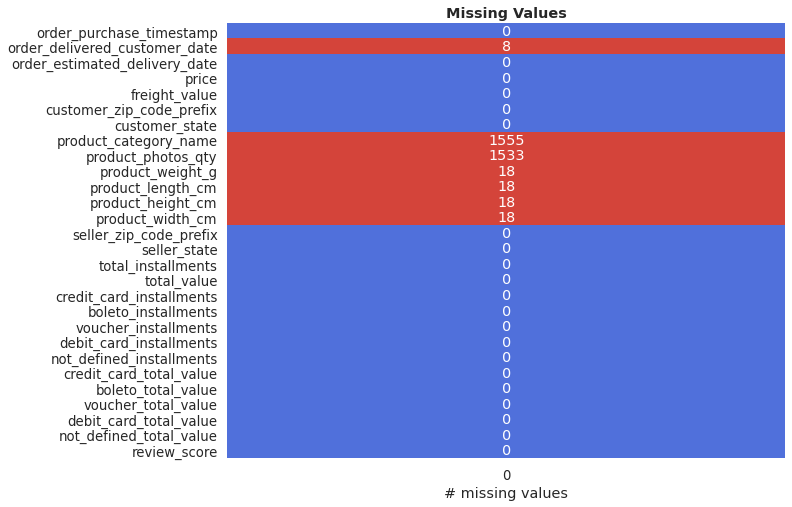

In [16]:
cmap = sns.diverging_palette(260, 14, as_cmap=True)
plt.figure(figsize = (10,8))
ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap=cmap, vmax=1, cbar=False)
plt.title('Missing Values', fontweight='bold')
ax.set_xlabel('# missing values')
plt.show()

As we can see in the visualization above, we have 7 columns containing missing data.

Most of them have only a few missing values, but `product_category_name` and `product_photos_qty` have a more than 1.5k missing values.

**order_delivered_customer_date**

In [17]:
print(f"> {df['order_delivered_customer_date'].isna().sum()} missing values")

> 8 missing values


There are only 8 missing values, so we'll drop these rows.

In [18]:
df.dropna(subset=["order_delivered_customer_date"], inplace=True)

**product_category_name**

In [19]:
print(f"> {df['product_category_name'].isna().sum()} missing values")

> 1555 missing values


We are going to create a new category for products without a category: `unspecified`

In [20]:
df['product_category_name'].fillna("unspecified", inplace=True)

**product_photos_qty**

In [21]:
print(f"> {df['product_photos_qty'].isna().sum()} missing values")
print(f"> Minimum value: {min(df['product_photos_qty'])}")

> 1533 missing values
> Minimum value: 1.0


The rows with a valid number of photos have a minimum value of 1. So we're going to consider that missing data in this column represents products without photos.

In [22]:
df['product_photos_qty'].fillna(0, inplace=True)

**Product Dimension** (weight, length, height, width)

In [23]:
print(f"> {df['product_weight_g'].isna().sum()} missing values")

> 18 missing values


There are only 18 missing values, so we'll drop these rows.

In [24]:
df.dropna(subset=["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"], inplace=True)

## 3. Feature Engineering

### Date/Time Features

In [26]:
# Identify the part of the day (potd) - purchase and delivery
df['purchase_potd'] = df['order_purchase_timestamp'].dt.hour.apply(identify_part_of_the_day)
df['delivery_potd'] = df['order_delivered_customer_date'].dt.hour.apply(identify_part_of_the_day)

# Identify the day of the week (dotw) - purchase and delivery
df['purchase_dotw'] = df['order_purchase_timestamp'].dt.day_name()
df['delivery_dotw'] = df['order_delivered_customer_date'].dt.day_name()

# Calculate how long it took to deliver the order (in days)
df['delivery_time_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# Calculate delays (in days)
df['delivery_delay_days'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days

# Identify if the order was delivered later than estimated
df['delivered_late'] = df['delivery_delay_days'].apply(lambda x: 1 if x > 0 else 0)

# Dropping original features
df.drop(columns=['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

,price,freight_value,customer_zip_code_prefix,customer_state,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_state,total_installments,total_value,credit_card_installments,boleto_installments,voucher_installments,debit_card_installments,not_defined_installments,credit_card_total_value,boleto_total_value,voucher_total_value,debit_card_total_value,not_defined_total_value,review_score,purchase_potd,delivery_potd,purchase_dotw,delivery_dotw,delivery_time_days,delivery_delay_days,delivered_late
0,29.99,8.72,03149,SP,housewares,4.0,500.0,19.0,8.0,13.0,09350,SP,3,38.71,1,0,2,0,0,18.12,0.00,20.59,0.00,0.0,4,morning,everning,Monday,Tuesday,8,7,1
1,29.99,7.78,03366,SP,housewares,4.0,500.0,19.0,8.0,13.0,09350,SP,3,37.77,3,0,0,0,0,37.77,0.00,0.00,0.00,0.0,4,everning,afternoon,Tuesday,Friday,2,9,1
2,29.99,7.78,02290,SP,housewares,4.0,500.0,19.0,8.0,13.0,09350,SP,1,37.77,1,0,0,0,0,37.77,0.00,0.00,0.00,0.0,5,everning,everning,Wednesday,Monday,5,7,1
3,29.99,14.10,88032,SC,housewares,4.0,500.0,19.0,8.0,13.0,09350,SP,1,44.09,0,1,0,0,0,0.00,44.09,0.00,0.00,0.0,3,night,everning,Monday,Tuesday,14,5,1
4,75.90,7.79,08577,SP,baby,3.0,238.0,20.0,10.0,15.0,09350,SP,1,83.69,1,0,0,0,0,83.69,0.00,0.00,0.00,0.0,5,afternoon,everning,Thursday,Wednesday,6,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112361,44.99,22.25,39810,MG,sports_leisure,2.0,600.0,30.0,20.0,20.0,88490,SC,2,134.48,2,0,0,0,0,134.48,0.00,0.00,0.00,0.0,5,everning,night,Friday,Tuesday,10,8,1
112364,79.00,14.13,08528,SP,construction_tools_lights,2.0,750.0,30.0,28.0,28.0,13660,SP,1,93.13,0,1,0,0,0,0.00,93.13,0.00,0.00,0.0,5,morning,afternoon,Sunday,Monday,8,10,1
112366,399.00,45.07,60455,CE,furniture_decor,2.0,2100.0,80.0,8.0,30.0,13478,SP,1,444.07,0,0,0,1,0,0.00,0.00,0.00,444.07,0.0,5,morning,night,Tuesday,Thursday,9,13,1
112367,219.90,24.12,39803,MG,furniture_decor,1.0,5900.0,41.0,21.0,41.0,08320,SP,4,244.02,4,0,0,0,0,244.02,0.00,0.00,0.00,0.0,4,everning,night,Tuesday,Tuesday,21,-5,0


In [ ]:
df